In [3]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [4]:
env = CliffWalkingEnv()

In [5]:
def make_epsilon_greedy_policy(Q1, Q2, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q1[observation] + Q2[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy and avoiding the maximization bias
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    # Keeps track of useful statistics
    episode_lengths= []
    episode_rewards= [] 
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q1, Q2, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print "\rEpisode {}/{}.".format(i_episode + 1, num_episodes)
            sys.stdout.flush()
        done = False
        s = env.reset()
        episode_l = 0
        episode_r = 0
        while not done:
            action = np.random.choice(np.arange(env.action_space.n), p=policy(s))
            new_s, r, done, _ = env.step(action)
            if np.random.random() > 0.5: 
                Q1[s][action] += alpha * (r + discount_factor * Q2[new_s][np.argmax(Q1[new_s])] - Q1[s][action])
            else:
                Q2[s][action] += alpha * (r + discount_factor * Q1[new_s][np.argmax(Q2[new_s])] - Q2[s][action])
            s = new_s
            episode_l += 1
            episode_r += r
        episode_r /= float(episode_l)
        episode_lengths.append(episode_l)
        episode_rewards.append(episode_r)

    stats = plotting.EpisodeStats(episode_lengths=np.array(episode_lengths), episode_rewards=np.array(episode_rewards))

    return Q1, stats

In [7]:
Q, stats = q_learning(env, 800)

Episode 100/800.
Episode 200/800.
Episode 300/800.
Episode 400/800.
Episode 500/800.
Episode 600/800.
Episode 700/800.
Episode 800/800.


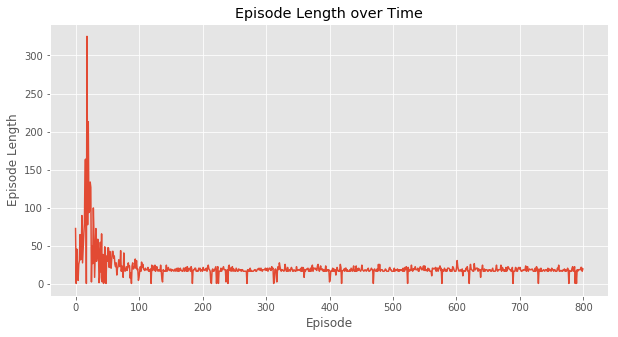

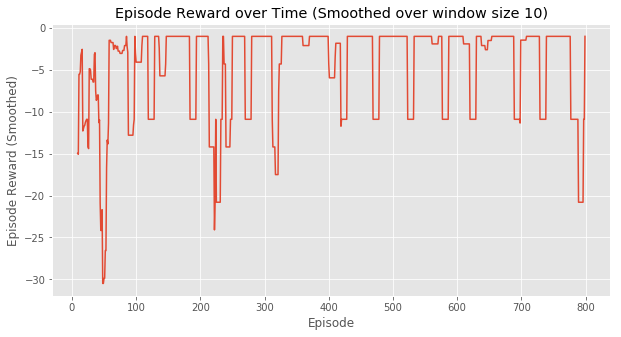

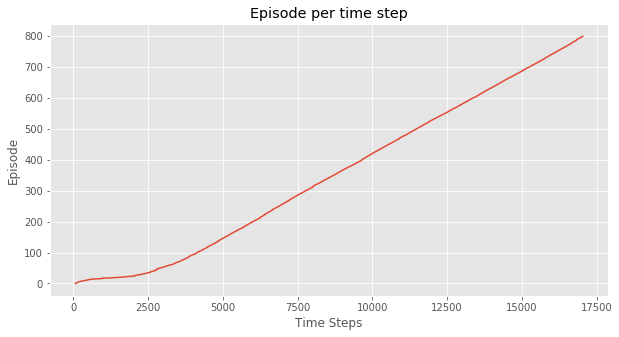

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plotting.plot_episode_stats(stats)

In [29]:
print np.random.random()

0.460058498157
